In [1]:
#@title Import libraries
import sys
import warnings

import pickle
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [2]:
# RL libraries
sys.path.append('resources')  # add source directoy to path
from resources import rnn, rnn_training, bandits, rnn_utils


In [3]:

# train model (BASELINE)
train = True
checkpoint = False
data = False

use_lstm = False

path_data = 'data/dataset_train.pkl'
params_path = 'params/params_lstm_b3.pkl'  # overwritten if data is False (adapted to the ground truth model)

# rnn parameters
hidden_size = 4
last_output = False
last_state = False
use_habit = False

# ensemble parameters
sampling_replacement = True
n_submodels = 1   # baseline model / no ensembling
ensemble = False
voting_type = rnn.EnsembleRNN.MEAN  # necessary if ensemble==True, can be mean or median

# tracked variables in the RNN
x_train_list = ['xQf','xQr']
control_list = ['ca','ca[k-1]', 'cr']
if use_habit:
  x_train_list += ['xHf']
sindy_feature_list = x_train_list + control_list

# training parameters
epochs = 8   # change to 100 (madd)
n_steps_per_call = 10  # None for full sequence
batch_size = None  # None for one batch per epoch
learning_rate = 1e-2
convergence_threshold = 1e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not data:
  # agent parameters
  agent_kw = 'basic'  #@param ['basic', 'quad_q'] 
  gen_alpha = .25 #@param
  gen_beta = 3 #@param
  forget_rate = 0. #@param
  perseverance_bias = 0. #@param
  # environment parameters
  non_binary_reward = False #@param
  n_actions = 2 #@param
  sigma = .1  #@param

  # dataset parameters
  n_trials_per_session = 200  #@param
  n_sessions = 64  #@param


  # setup
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma, n_actions=n_actions, non_binary_rewards=non_binary_reward)
  agent = bandits.AgentQ(gen_alpha, gen_beta, n_actions, forget_rate, perseverance_bias)  

  dataset_train, experiment_list_train = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions,
      device=device)

  dataset_test, experiment_list_test = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=200,  #n_trials_per_session,
      n_sessions=1024,
      device=device)
  
  params_path = rnn_utils.parameter_file_naming(
      'params/params',
      use_lstm,
      last_output,
      last_state,
      use_habit,
      gen_beta,
      forget_rate,
      perseverance_bias,
      non_binary_reward,
      verbose=True,
  )
  
else:
  # load data
  with open(path_data, 'rb') as f:
      dataset_train = pickle.load(f)

# define model
if use_lstm:
  model = rnn.LSTM(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      device=device,
      ).to(device)
else:
  model = rnn.RLRNN(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      last_output=last_output,
      last_state=last_state,
      use_habit=use_habit,
      device=device,
      list_sindy_signals=sindy_feature_list,
      ).to(device)

optimizer_rnn = torch.optim.Adam(model.parameters(), lr=learning_rate)


Automatically generated name for model parameter file: params/params_rnn_b3.pkl.


In [5]:

if train:
  if checkpoint:
    # load trained parameters
    state_dict = torch.load(params_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict['model'])
    optimizer_rnn.load_state_dict(state_dict['optimizer'])
    print('Loaded parameters.')
  
  start_time = time.time()
  
  #Fit the hybrid RNN
  print('Training the hybrid RNN...')
  model, optimizer_rnn, training_loss = rnn_training.fit_model(
      model=model,
      dataset=dataset_train,
      optimizer=optimizer_rnn,
      convergence_threshold=convergence_threshold,
      epochs=epochs,
      n_steps_per_call = n_steps_per_call,
      batch_size=batch_size,
      n_submodels=n_submodels,
      return_ensemble=ensemble,
      voting_type=voting_type,
      sampling_replacement=sampling_replacement,
  )

    # validate model
  print('\nValidating the trained hybrid RNN on a test dataset...')
  with torch.no_grad():
    model, optimizer_rnn, val_loss = rnn_training.fit_model(     #val_loss gets the final validation loss
        model=model,
        dataset=dataset_test,
        n_steps_per_call=10,  # 1
    )

  print(f'Training took {time.time() - start_time:.2f} seconds.')
  
  
  # save trained parameters  
  state_dict = {
    'model': model.state_dict() if isinstance(model, torch.nn.Module) else [model_i.state_dict() for model_i in model],
    'optimizer': optimizer_rnn.state_dict() if isinstance(optimizer_rnn, torch.optim.Adam) else [optim_i.state_dict() for optim_i in optimizer_rnn],
  }
  torch.save(state_dict, params_path)

else:
  # load trained parameters
  model.load_state_dict(torch.load(params_path)['model'])
  print(f'Loaded parameters from file {params_path}.')

# if hasattr(model, 'beta'):
#   print(f'beta: {model.beta}')

# Synthesize a dataset using the fitted network
environment = bandits.EnvironmentBanditsDrift(0.1)
model.set_device(torch.device('cpu'))
model.to(torch.device('cpu'))
rnn_agent = bandits.AgentNetwork(model, n_actions=2, habit=use_habit)
# dataset_rnn, experiment_list_rnn = bandits.create_dataset(rnn_agent, environment, 220, 10)

  

Training the hybrid RNN...
Epoch 1/8 --- Loss: 0.5193203; Time: 1.1s; Convergence value: 4.81e-01
Epoch 2/8 --- Loss: 0.4739977; Time: 1.7s; Convergence value: 2.54e-01
Epoch 3/8 --- Loss: 0.5041838; Time: 1.5s; Convergence value: 1.72e-01
Epoch 4/8 --- Loss: 0.5106617; Time: 1.5s; Convergence value: 1.24e-01
Epoch 5/8 --- Loss: 0.4998120; Time: 1.0s; Convergence value: 9.51e-02
Epoch 6/8 --- Loss: 0.5079645; Time: 1.2s; Convergence value: 7.51e-02
Epoch 7/8 --- Loss: 0.5273385; Time: 1.4s; Convergence value: 6.24e-02
Epoch 8/8 --- Loss: 0.5244249; Time: 1.5s; Convergence value: 1.53e-02
Maximum number of training epochs reached.
Model did not converge yet.

Validating the trained hybrid RNN on a test dataset...
Epoch 1/1 --- Loss: 0.5336977; Time: 1.4s; Convergence value: nan
Maximum number of training epochs reached.
Model did not converge yet.
Training took 12.35 seconds.


In [6]:
loss_baseline =training_loss

[0.5193203091621399,
 0.47399768233299255,
 0.504183828830719,
 0.5106617212295532,
 0.4998120367527008,
 0.5079644918441772,
 0.5273385047912598,
 0.5244249105453491]

In [11]:
# 2 submodels

# train model
train = True
checkpoint = False
data = False

use_lstm = False

path_data = 'data/dataset_train.pkl'
params_path = 'params/params_lstm_b3.pkl'  # overwritten if data is False (adapted to the ground truth model)

# rnn parameters
hidden_size = 4
last_output = False
last_state = False
use_habit = False

# ensemble parameters
sampling_replacement = True
n_submodels = 2   
ensemble = False
voting_type = rnn.EnsembleRNN.MEAN  # necessary if ensemble==True, can be mean or median

# tracked variables in the RNN
x_train_list = ['xQf','xQr']
control_list = ['ca','ca[k-1]', 'cr']
if use_habit:
  x_train_list += ['xHf']
sindy_feature_list = x_train_list + control_list

# training parameters
epochs = 8
n_steps_per_call = 10  # None for full sequence
batch_size = None  # None for one batch per epoch
learning_rate = 1e-2
convergence_threshold = 1e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not data:
  # agent parameters
  agent_kw = 'basic'  #@param ['basic', 'quad_q'] 
  gen_alpha = .25 #@param
  gen_beta = 3 #@param
  forget_rate = 0. #@param
  perseverance_bias = 0. #@param
  # environment parameters
  non_binary_reward = False #@param
  n_actions = 2 #@param
  sigma = .1  #@param

  # dataset parameters
  n_trials_per_session = 200  #@param
  n_sessions = 64  #@param


  # setup
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma, n_actions=n_actions, non_binary_rewards=non_binary_reward)
  agent = bandits.AgentQ(gen_alpha, gen_beta, n_actions, forget_rate, perseverance_bias)  

  dataset_train, experiment_list_train = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions,
      device=device)

  dataset_test, experiment_list_test = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=200,#n_trials_per_session,
      n_sessions=1024,
      device=device)
  
  params_path = rnn_utils.parameter_file_naming(
      'params/params',
      use_lstm,
      last_output,
      last_state,
      use_habit,
      gen_beta,
      forget_rate,
      perseverance_bias,
      non_binary_reward,
      verbose=True,
  )
  
else:
  # load data
  with open(path_data, 'rb') as f:
      dataset_train = pickle.load(f)

# define model
if use_lstm:
  model = rnn.LSTM(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      device=device,
      ).to(device)
else:
  model = rnn.RLRNN(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      last_output=last_output,
      last_state=last_state,
      use_habit=use_habit,
      device=device,
      list_sindy_signals=sindy_feature_list,
      ).to(device)

optimizer_rnn = torch.optim.Adam(model.parameters(), lr=learning_rate)

if train:
  if checkpoint:
    # load trained parameters
    state_dict = torch.load(params_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict['model'])
    optimizer_rnn.load_state_dict(state_dict['optimizer'])
    print('Loaded parameters.')
  
  start_time = time.time()
  
  #Fit the hybrid RNN
  print('Training the hybrid RNN...')
  model, optimizer_rnn, training_loss = rnn_training.fit_model(
      model=model,
      dataset=dataset_train,
      optimizer=optimizer_rnn,
      convergence_threshold=convergence_threshold,
      epochs=epochs,
      n_steps_per_call = n_steps_per_call,
      batch_size=batch_size,
      n_submodels=n_submodels,
      return_ensemble=ensemble,
      voting_type=voting_type,
      sampling_replacement=sampling_replacement,
  )
  

  # validate model
  print('\nValidating the trained hybrid RNN on a test dataset...')
  with torch.no_grad():
    model, optimizer_rnn, val_loss = rnn_training.fit_model(     #val_loss gets the final validation loss
        model=model,
        dataset=dataset_test,
        n_steps_per_call=1,
    )

  print(f'Training took {time.time() - start_time:.2f} seconds.')
  
  
  # save trained parameters  
  state_dict = {
    'model': model.state_dict() if isinstance(model, torch.nn.Module) else [model_i.state_dict() for model_i in model],
    'optimizer': optimizer_rnn.state_dict() if isinstance(optimizer_rnn, torch.optim.Adam) else [optim_i.state_dict() for optim_i in optimizer_rnn],
  }
  torch.save(state_dict, params_path)

else:
  # load trained parameters
  model.load_state_dict(torch.load(params_path)['model'])
  print(f'Loaded parameters from file {params_path}.')

# if hasattr(model, 'beta'):
#   print(f'beta: {model.beta}')

# Synthesize a dataset using the fitted network
environment = bandits.EnvironmentBanditsDrift(0.1)
model.set_device(torch.device('cpu'))
model.to(torch.device('cpu'))
rnn_agent = bandits.AgentNetwork(model, n_actions=2, habit=use_habit)
# dataset_rnn, experiment_list_rnn = bandits.create_dataset(rnn_agent, environment, 220, 10)



Automatically generated name for model parameter file: params/params_rnn_b3.pkl.
Training the hybrid RNN...
Epoch 1/8 --- Loss: 0.6787878; Time: 1.0s; Convergence value: 3.21e-01
Epoch 2/8 --- Loss: 0.6469809; Time: 1.2s; Convergence value: 1.70e-01
Epoch 3/8 --- Loss: 0.6366155; Time: 1.5s; Convergence value: 1.12e-01
Epoch 4/8 --- Loss: 0.5911596; Time: 1.8s; Convergence value: 9.21e-02
Epoch 5/8 --- Loss: 0.5332860; Time: 1.4s; Convergence value: 8.31e-02
Epoch 6/8 --- Loss: 0.5393184; Time: 1.2s; Convergence value: 6.60e-02
Epoch 7/8 --- Loss: 0.5730918; Time: 1.3s; Convergence value: 5.86e-02
Epoch 8/8 --- Loss: 0.5614646; Time: 1.2s; Convergence value: 2.73e-02
Maximum number of training epochs reached.
Model did not converge yet.

Validating the trained hybrid RNN on a test dataset...
Epoch 1/1 --- Loss: 0.5262137; Time: 1.0s; Convergence value: nan
Maximum number of training epochs reached.
Model did not converge yet.
Training took 11.42 seconds.


In [13]:
n2_loss = training_loss

In [38]:
# 3 submodels

# train model
train = True
checkpoint = False
data = False

use_lstm = False

path_data = 'data/dataset_train.pkl'
params_path = 'params/params_lstm_b3.pkl'  # overwritten if data is False (adapted to the ground truth model)

# rnn parameters
hidden_size = 4
last_output = False
last_state = False
use_habit = False

# ensemble parameters
sampling_replacement = True
n_submodels = 3   
ensemble = False
voting_type = rnn.EnsembleRNN.MEAN  # necessary if ensemble==True, can be mean or median

# tracked variables in the RNN
x_train_list = ['xQf','xQr']
control_list = ['ca','ca[k-1]', 'cr']
if use_habit:
  x_train_list += ['xHf']
sindy_feature_list = x_train_list + control_list

# training parameters
epochs = 8
n_steps_per_call = 10  # None for full sequence
batch_size = None  # None for one batch per epoch
learning_rate = 1e-2
convergence_threshold = 1e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not data:
  # agent parameters
  agent_kw = 'basic'  #@param ['basic', 'quad_q'] 
  gen_alpha = .25 #@param
  gen_beta = 3 #@param
  forget_rate = 0. #@param
  perseverance_bias = 0. #@param
  # environment parameters
  non_binary_reward = False #@param
  n_actions = 2 #@param
  sigma = .1  #@param

  # dataset parameters
  n_trials_per_session = 200  #@param
  n_sessions = 64  #@param


  # setup
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma, n_actions=n_actions, non_binary_rewards=non_binary_reward)
  agent = bandits.AgentQ(gen_alpha, gen_beta, n_actions, forget_rate, perseverance_bias)  

  dataset_train, experiment_list_train = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions,
      device=device)

  dataset_test, experiment_list_test = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=200,#n_trials_per_session,
      n_sessions=1024,
      device=device)
  
  params_path = rnn_utils.parameter_file_naming(
      'params/params',
      use_lstm,
      last_output,
      last_state,
      use_habit,
      gen_beta,
      forget_rate,
      perseverance_bias,
      non_binary_reward,
      verbose=True,
  )
  
else:
  # load data
  with open(path_data, 'rb') as f:
      dataset_train = pickle.load(f)

# define model
if use_lstm:
  model = rnn.LSTM(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      device=device,
      ).to(device)
else:
  model = rnn.RLRNN(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      last_output=last_output,
      last_state=last_state,
      use_habit=use_habit,
      device=device,
      list_sindy_signals=sindy_feature_list,
      ).to(device)

optimizer_rnn = torch.optim.Adam(model.parameters(), lr=learning_rate)

if train:
  if checkpoint:
    # load trained parameters
    state_dict = torch.load(params_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict['model'])
    optimizer_rnn.load_state_dict(state_dict['optimizer'])
    print('Loaded parameters.')
  
  start_time = time.time()
  
  #Fit the hybrid RNN
  print('Training the hybrid RNN...')
  model, optimizer_rnn, training_loss = rnn_training.fit_model(
      model=model,
      dataset=dataset_train,
      optimizer=optimizer_rnn,
      convergence_threshold=convergence_threshold,
      epochs=epochs,
      n_steps_per_call = n_steps_per_call,
      batch_size=batch_size,
      n_submodels=n_submodels,
      return_ensemble=ensemble,
      voting_type=voting_type,
      sampling_replacement=sampling_replacement,
  )
  

  # validate model
  print('\nValidating the trained hybrid RNN on a test dataset...')
  with torch.no_grad():
    model, optimizer_rnn, val_loss = rnn_training.fit_model(     #val_loss gets the final validation loss
        model=model,
        dataset=dataset_test,
        n_steps_per_call=1,
    )

  print(f'Training took {time.time() - start_time:.2f} seconds.')
  
  
  # save trained parameters  
  state_dict = {
    'model': model.state_dict() if isinstance(model, torch.nn.Module) else [model_i.state_dict() for model_i in model],
    'optimizer': optimizer_rnn.state_dict() if isinstance(optimizer_rnn, torch.optim.Adam) else [optim_i.state_dict() for optim_i in optimizer_rnn],
  }
  torch.save(state_dict, params_path)

else:
  # load trained parameters
  model.load_state_dict(torch.load(params_path)['model'])
  print(f'Loaded parameters from file {params_path}.')

# if hasattr(model, 'beta'):
#   print(f'beta: {model.beta}')

# Synthesize a dataset using the fitted network
environment = bandits.EnvironmentBanditsDrift(0.1)
model.set_device(torch.device('cpu'))
model.to(torch.device('cpu'))
rnn_agent = bandits.AgentNetwork(model, n_actions=2, habit=use_habit)
# dataset_rnn, experiment_list_rnn = bandits.create_dataset(rnn_agent, environment, 220, 10)



Automatically generated name for model parameter file: params/params_rnn_b3.pkl.
Training the hybrid RNN...
Epoch 1/8 --- Loss: 0.6772497; Time: 1.8s; Convergence value: 3.23e-01
Epoch 2/8 --- Loss: 0.6231037; Time: 1.7s; Convergence value: 1.83e-01
Epoch 3/8 --- Loss: 0.5791623; Time: 1.7s; Convergence value: 1.32e-01
Epoch 4/8 --- Loss: 0.5641721; Time: 1.5s; Convergence value: 9.78e-02
Epoch 5/8 --- Loss: 0.5585765; Time: 1.6s; Convergence value: 7.48e-02
Epoch 6/8 --- Loss: 0.5583069; Time: 1.4s; Convergence value: 5.79e-02
Epoch 7/8 --- Loss: 0.5483661; Time: 1.3s; Convergence value: 4.73e-02
Epoch 8/8 --- Loss: 0.5693092; Time: 2.3s; Convergence value: 1.85e-02
Maximum number of training epochs reached.
Model did not converge yet.

Validating the trained hybrid RNN on a test dataset...
Epoch 1/1 --- Loss: 0.5486189; Time: 0.7s; Convergence value: nan
Maximum number of training epochs reached.
Model did not converge yet.
Training took 14.09 seconds.


In [39]:
n3_loss = training_loss

In [12]:
import seaborn as sns
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [52]:
d = {'Baseline': loss_baseline, 'n = 2': n2_loss, 'n = 3': n3_loss }
df = pd.DataFrame(data=d)
df

,Baseline,n = 2,n = 3
0,0.519320,0.678788,0.677250
1,0.473998,0.646981,0.623104
2,0.504184,0.636616,0.579162
3,0.510662,0.591160,0.564172
4,0.499812,0.533286,0.558577
5,0.507964,0.539318,0.558307
6,0.527339,0.573092,0.548366
7,0.524425,0.561465,0.569309


In [53]:
df["Epoch"] = df.index+1

df1 = pd.melt(df, id_vars=['Epoch'], value_vars=['Baseline', 'n = 2', 'n = 3'])

df2 = df1.rename(columns={"variable": "model", "value": "loss"})


In [54]:
df2

,Epoch,model,loss
0,1,Baseline,0.519320
1,2,Baseline,0.473998
2,3,Baseline,0.504184
3,4,Baseline,0.510662
4,5,Baseline,0.499812
5,6,Baseline,0.507964
6,7,Baseline,0.527339
7,8,Baseline,0.524425
8,1,n = 2,0.678788
9,2,n = 2,0.646981


<AxesSubplot:xlabel='model', ylabel='loss'>

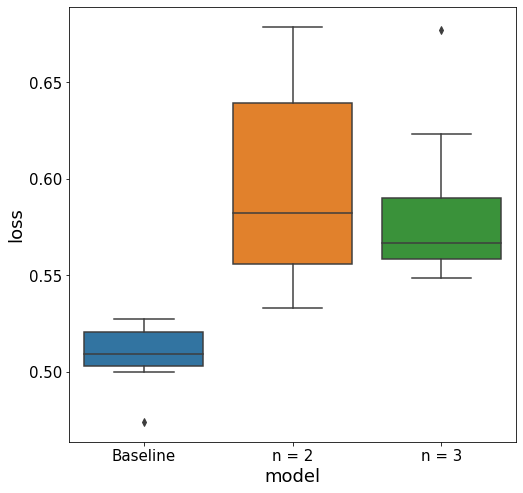

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))

sns.boxplot(data=df2, x="model", y="loss")

#ax.set(ylim=(0, 1))


<AxesSubplot:xlabel='Epoch', ylabel='loss'>

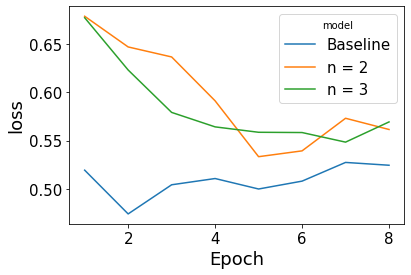

In [56]:
sns.lineplot(data=df2, x="Epoch", y="loss", hue="model")

In [ ]:
# 2 submodels, no replacement


# train model
train = True
checkpoint = False
data = False

use_lstm = False

path_data = 'data/dataset_train.pkl'
params_path = 'params/params_lstm_b3.pkl'  # overwritten if data is False (adapted to the ground truth model)

# rnn parameters
hidden_size = 4
last_output = False
last_state = False
use_habit = False

# ensemble parameters
sampling_replacement = False
n_submodels = 2   
ensemble = False  #  True averages the output of each model
voting_type = rnn.EnsembleRNN.MEAN  # necessary if ensemble==True, can be mean or median

# tracked variables in the RNN
x_train_list = ['xQf','xQr']
control_list = ['ca','ca[k-1]', 'cr']
if use_habit:
  x_train_list += ['xHf']
sindy_feature_list = x_train_list + control_list

# training parameters
epochs = 8
n_steps_per_call = 10  # None for full sequence
batch_size = None  # None for one batch per epoch
learning_rate = 1e-2
convergence_threshold = 1e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not data:
  # agent parameters
  agent_kw = 'basic'  #@param ['basic', 'quad_q'] 
  gen_alpha = .25 #@param
  gen_beta = 3 #@param
  forget_rate = 0. #@param
  perseverance_bias = 0. #@param
  # environment parameters
  non_binary_reward = False #@param
  n_actions = 2 #@param
  sigma = .1  #@param

  # dataset parameters
  n_trials_per_session = 200  #@param
  n_sessions = 64  #@param


  # setup
  environment = bandits.EnvironmentBanditsDrift(sigma=sigma, n_actions=n_actions, non_binary_rewards=non_binary_reward)
  agent = bandits.AgentQ(gen_alpha, gen_beta, n_actions, forget_rate, perseverance_bias)  

  dataset_train, experiment_list_train = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=n_trials_per_session,
      n_sessions=n_sessions,
      device=device)

  dataset_test, experiment_list_test = bandits.create_dataset(
      agent=agent,
      environment=environment,
      n_trials_per_session=200,#n_trials_per_session,
      n_sessions=1024,
      device=device)
  
  params_path = rnn_utils.parameter_file_naming(
      'params/params',
      use_lstm,
      last_output,
      last_state,
      use_habit,
      gen_beta,
      forget_rate,
      perseverance_bias,
      non_binary_reward,
      verbose=True,
  )
  
else:
  # load data
  with open(path_data, 'rb') as f:
      dataset_train = pickle.load(f)

# define model
if use_lstm:
  model = rnn.LSTM(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      device=device,
      ).to(device)
else:
  model = rnn.RLRNN(
      n_actions=n_actions, 
      hidden_size=hidden_size, 
      init_value=0.5,
      last_output=last_output,
      last_state=last_state,
      use_habit=use_habit,
      device=device,
      list_sindy_signals=sindy_feature_list,
      ).to(device)

optimizer_rnn = torch.optim.Adam(model.parameters(), lr=learning_rate)

if train:
  if checkpoint:
    # load trained parameters
    state_dict = torch.load(params_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict['model'])
    optimizer_rnn.load_state_dict(state_dict['optimizer'])
    print('Loaded parameters.')
  
  start_time = time.time()
  
  #Fit the hybrid RNN
  print('Training the hybrid RNN...')
  model, optimizer_rnn, training_loss = rnn_training.fit_model(
      model=model,
      dataset=dataset_train,
      optimizer=optimizer_rnn,
      convergence_threshold=convergence_threshold,
      epochs=epochs,
      n_steps_per_call = n_steps_per_call,
      batch_size=batch_size,
      n_submodels=n_submodels,
      return_ensemble=ensemble,
      voting_type=voting_type,
      sampling_replacement=sampling_replacement,
  )
  

  # validate model
  print('\nValidating the trained hybrid RNN on a test dataset...')
  with torch.no_grad():
    model, optimizer_rnn, val_loss = rnn_training.fit_model(     #val_loss gets the final validation loss
        model=model,
        dataset=dataset_test,
        n_steps_per_call=1,
    )

  print(f'Training took {time.time() - start_time:.2f} seconds.')
  
  
  # save trained parameters  
  state_dict = {
    'model': model.state_dict() if isinstance(model, torch.nn.Module) else [model_i.state_dict() for model_i in model],
    'optimizer': optimizer_rnn.state_dict() if isinstance(optimizer_rnn, torch.optim.Adam) else [optim_i.state_dict() for optim_i in optimizer_rnn],
  }
  torch.save(state_dict, params_path)

else:
  # load trained parameters
  model.load_state_dict(torch.load(params_path)['model'])
  print(f'Loaded parameters from file {params_path}.')

# if hasattr(model, 'beta'):
#   print(f'beta: {model.beta}')

# Synthesize a dataset using the fitted network
environment = bandits.EnvironmentBanditsDrift(0.1)
model.set_device(torch.device('cpu'))
model.to(torch.device('cpu'))
rnn_agent = bandits.AgentNetwork(model, n_actions=2, habit=use_habit)
# dataset_rnn, experiment_list_rnn = bandits.create_dataset(rnn_agent, environment, 220, 10)

